# Installing Modules

In [1]:
!pip install -qq pytorch_lightning==1.4.0 tableprint wget
!pip install -qq datasets transformers[sentencepiece]

     |████████████████████████████████| 913 kB 8.3 MB/s 
     |████████████████████████████████| 829 kB 58.9 MB/s 
     |████████████████████████████████| 636 kB 56.7 MB/s 
     |████████████████████████████████| 272 kB 68.3 MB/s 
     |████████████████████████████████| 118 kB 73.8 MB/s 
     |████████████████████████████████| 5.6 MB 71.3 MB/s 
     |████████████████████████████████| 1.3 MB 63.0 MB/s 
     |████████████████████████████████| 294 kB 53.3 MB/s 
     |████████████████████████████████| 142 kB 66.0 MB/s 
     |████████████████████████████████| 264 kB 8.0 MB/s 
     |████████████████████████████████| 2.6 MB 57.4 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 243 kB 66.7 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 3.3 MB 27.3 MB/s 
     |████████████████████████████████| 895 kB 66.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.0 MB/s 


# Imports

In [2]:
##############
### Basics ###
##############
import numpy as np
import pandas as pd
import random
import math, time

##############
### Torch  ###
##############
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

##############
#### Plots ###
##############
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker

##################
## Transformers ##
##################
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, load_metric

##############
#### Misc ####
##############
import tableprint as tp


In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model_checkpoint = "bert-base-uncased"

# Downloading Dataset

In [6]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [7]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


# Data Preprocessing

In [8]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
4749,ks08,1,NaN,Which man did you talk to?
7987,ad03,1,NaN,What she thought was that the poison was neutr...
3851,ks08,1,NaN,The teacher made students happy.
8430,ad03,0,*,I have sent 0 letter to Environmental Heath
7780,ad03,0,*,We believed to be omnipotent.
4143,ks08,1,NaN,Students studying English read Conrad's Heart ...
2593,l-93,1,NaN,Jessica sprayed paint over the table.
7964,ad03,1,NaN,He might no could have done it
6828,m_02,1,NaN,How is someone to chat to a girl if she does n...
7212,sks13,1,NaN,What John became was deadly afraid of flying.


In [9]:
sentences = df.sentence.values
labels = df.label.values

## 'Unacceptable' Samples

In [10]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
7039,Which books did Robin talk to Chris and read?,0
6124,It was kissed her.,0
460,The boat sank to collect the insurance.,0
5139,It is Kim on whom that Sandy relies.,0
1385,What time did you arrive at?,0


## 'Acceptable' Samples

In [11]:
df.loc[df.label == 1].sample(5)[['sentence', 'label']]

,sentence,label
5974,Jeff must not have eaten the deep fried muffin.,1
3264,The hair dryer dried the clothes.,1
1329,Harry will be in the Marines next year and Her...,1
7754,He might could go,1
5318,"Hate those who criticize Carter though he may,...",1


# Tokenization

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True,
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Creating Dataset

In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


# Creating DataLoaders

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
BATCH_SIZE = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

# Model

In [16]:
# automodel = AutoModel.from_pretrained(MODEL_NAME, return_dict = True)

automodel = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
class Model(pl.LightningModule):
    def __init__(self, model, steps_per_epoch, n_epochs):
        super(Model, self).__init__()
        self.model = model
        self.train_loss = torch.tensor([])
        self.avg_train_loss = 0.
        self.train_acc =  torch.tensor(0.)
        self.table_context = None
        # self.loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        self.start_time = 0
        self.end_time = 0
        self.epoch_mins = 0
        self.epoch_secs = 0
        self.avg_train_loss = 0.
        self.table_context = None
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        # self.train_accm = torchmetrics.Accuracy(num_classes=2)
        # self.valid_accm = torchmetrics.Accuracy(num_classes=2)
        self.total_train_accuracy = 0.
        self.total_eval_accuracy = 0.
        self.avg_train_accuracy = 0.

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)

        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(
                                                    optimizer,
                                                    warmup_steps,
                                                    total_steps
                                                    ) 
        return [optimizer], [scheduler]

    def forward(self, input_ids, token_type_ids, attention_mask, labels = None, return_dict = True):
        output = self.model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels, return_dict=True)
        
        if labels != None:
            loss = output.loss
        logits = output.logits
               
        return output
    
    def on_train_epoch_start(self):
        self.train_loss = torch.tensor([])

    def step(self, batch):

        input_ids = batch[0]
        input_mask = batch[1]
        labels = batch[2]
        output = self(input_ids, 
                       token_type_ids=None, 
                       attention_mask=input_mask, 
                       labels=labels,
                       return_dict=True)
        
        
        
        loss = output.loss
        logits = output.logits

 
        return {"loss": loss, 'logits': logits}


    def training_step(self, batch, batch_idx):
        # target = batch[2]
        # predictions = torch.argmax(self.step(batch)['logits'], dim=1)
        # acc_train = self.train_accm(predictions, target)

        output = self.step(batch)
        loss = output['loss']
        self.train_loss =  torch.cat((self.train_loss, torch.tensor([loss])), 0)

        target = batch[2].to('cpu').numpy()
        logits = output['logits'].detach().cpu().numpy()
        self.total_train_accuracy += flat_accuracy(logits, target)

        return loss
    
    def validation_step(self, batch, batch_idx):
        # target = batch[2]
        # predictions = torch.argmax(self.step(batch)['logits'], dim=1)
        # acc_valid = self.valid_accm(predictions, target)
        
        output = self.step(batch)
        target = batch[2].to('cpu').numpy()
        logits = output['logits'].detach().cpu().numpy()
        self.total_eval_accuracy += flat_accuracy(logits, target)

        return output
    
    def on_validation_epoch_start(self):
        self.avg_train_loss = self.train_loss.mean().item()
        self.train_loss = torch.tensor([])
        self.avg_train_accuracy = self.total_train_accuracy / len(train_loader) * 100
        self.total_train_accuracy = 0.
        # self.train_acc = self.train_accm.compute() * 100
        # self.train_accm.reset()

    def validation_epoch_end(self, outputs):
        if self.trainer.sanity_checking:
          return
        self.end_time = time.time()
        self.epoch_mins, self.epoch_secs = self.epoch_time(self.start_time, self.end_time)
        time_int = f'{self.epoch_mins}m {self.epoch_secs}s'
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean().item()
        # valid_acc = self.valid_accm.compute() * 100
        # self.valid_accm.reset()
        avg_eval_accuracy = self.total_eval_accuracy / len(val_loader) * 100
        self.total_eval_accuracy = 0.
        metrics = {'epoch': self.current_epoch+1, 'Train Acc': self.avg_train_accuracy, 'Train Loss': self.avg_train_loss,  'Valid Acc': avg_eval_accuracy, 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train Acc', 'Train Loss', 'Valid Acc', 'Valid Loss', 'Time'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, self.avg_train_accuracy, self.avg_train_loss, avg_eval_accuracy, avg_valid_loss, time_int])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.table_context.__exit__()
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    def on_train_epoch_start(self):
        self.start_time = time.time()

In [20]:
N_EPOCHS = 10

model = Model(
            model = automodel,
            steps_per_epoch=len(train_dataset) // BATCH_SIZE,
            n_epochs = N_EPOCHS
            )

# Training

In [21]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_14_2', version=0)
trainer = pl.Trainer(max_epochs=10, num_sanity_val_steps=1, logger=csvlogger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [22]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train Acc │  Train Loss │   Valid Acc │  Valid Loss │        Time │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      32.178 │     0.85939 │      29.128 │     0.91791 │      1m 28s │


Validating: 0it [00:00, ?it/s]

│           2 │      49.576 │     0.72285 │      66.975 │     0.64031 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           3 │      69.156 │      0.6178 │      72.647 │     0.58501 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           4 │      70.118 │     0.60395 │      72.878 │     0.56774 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           5 │      71.349 │     0.56989 │      76.852 │     0.50673 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           6 │      75.517 │     0.51363 │      78.897 │     0.48541 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           7 │      78.416 │     0.46718 │      81.327 │     0.45948 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           8 │      81.776 │     0.42354 │      82.022 │     0.44333 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│           9 │      83.467 │     0.38893 │      82.407 │     0.43989 │      1m 29s │


Validating: 0it [00:00, ?it/s]

│          10 │      84.866 │     0.35774 │      83.449 │     0.43183 │      1m 29s │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯


# Training Logs

In [23]:
root='./csv_logs/' + 'END2_Assign_14_2' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

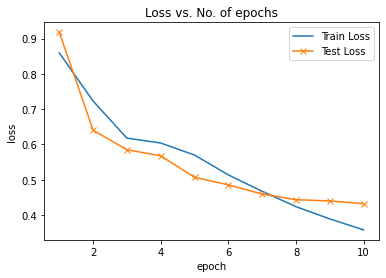

In [24]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

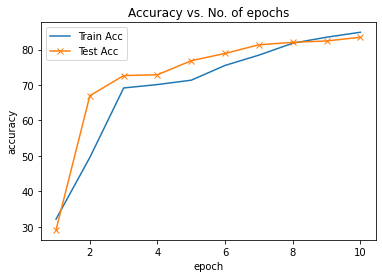

In [25]:
plt.plot(metrics['epoch'], metrics['Train Acc'], label="Train Acc")
plt.plot(metrics['epoch'], metrics['Valid Acc'], '-x', label="Test Acc")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of epochs');

# Evaluation on Test Data

## Data Preparation

In [28]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [29]:
%%capture
model.to(device)
model.eval()

In [30]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     labels = None,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [31]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [32]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


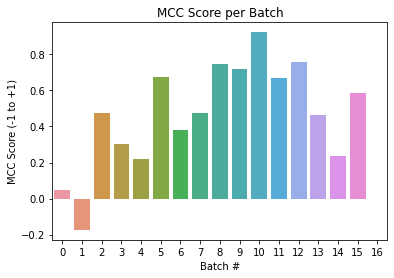

In [33]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [34]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.498
